## (1) Import libraries

In [1]:
import pandas as pd
import sklearn.preprocessing
import sklearn.metrics
from pycaret.datasets import get_data

import autosklearn.regression
import matplotlib.pyplot as plt

In [2]:
# Record version of key libraries
from importlib.metadata import version

print('auto-sklearn==%s' % version('auto-sklearn'))

auto-sklearn==0.13.0


## (2) Get data

In [3]:
# Get a list of all pre-packaged data
# get_data('index')

# Select a pre-packaged data for testing
data = get_data('diamond')

Carat Weight    Cut Color Clarity Polish Symmetry Report  Price
0          1.10  Ideal     H     SI1     VG       EX    GIA   5169
1          0.83  Ideal     H     VS1     ID       ID   AGSL   3470
2          0.85  Ideal     H     SI1     EX       EX    GIA   3183
3          0.91  Ideal     E     SI1     VG       VG    GIA   4370
4          0.83  Ideal     G     SI1     EX       EX    GIA   3171

In [4]:
# Encode categorical data into values
# NOTE - all data needs to be numerical to be processed by auto-sklearn
# NOTE - categorical strings need to be converted into integers, e.g. using sklearn LabelEncoder
# NOTE - it is best to save fitted labelencoder objects for each feature to be used with new data or future pipeline
le_enc = sklearn.preprocessing.LabelEncoder()
data['Cut'] = le_enc.fit_transform(data['Cut'])
data['Color'] = le_enc.fit_transform(data['Color'])
data['Clarity'] = le_enc.fit_transform(data['Clarity'])
data['Polish'] = le_enc.fit_transform(data['Polish'])
data['Symmetry'] = le_enc.fit_transform(data['Symmetry'])
data['Report'] = le_enc.fit_transform(data['Report'])

# Split data into X and y in numpy array (as numpy array is better supported by auto-sklearn)
X = data.iloc[:,:-1].to_numpy()
y = data.iloc[:,-1].to_numpy()

# Specify types of features - can only be either categorical or numerical. Categorical feature will get one-hot encoded
# Must be specified for each column
feat_type = [
    'Numerical', 'Categorical', 'Categorical', 'Categorical', 
    'Categorical', 'Categorical', 'Categorical'
]

# Split data into training and testing data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=6)

display(X)
display(y)

array([[1.1 , 2.  , 4.  , ..., 3.  , 0.  , 1.  ],
       [0.83, 2.  , 4.  , ..., 2.  , 2.  , 0.  ],
       [0.85, 2.  , 4.  , ..., 0.  , 0.  , 1.  ],
       ...,
       [1.02, 2.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [1.27, 3.  , 3.  , ..., 0.  , 0.  , 1.  ],
       [2.19, 2.  , 1.  , ..., 0.  , 0.  , 1.  ]])

array([ 5169,  3470,  3183, ...,  6157, 11206, 30507])

## (3) Setup model object

In [5]:
# Setup automl model
# NOTE - AutoSklearn2Classifier is an improved version of AutoSklearnClassifier, but currently as experimental feature
# NOTE - change resampling_strategy from default will lead to error in automl.predict()

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    ensemble_size=50,
    ensemble_nbest=10,
    # resampling_strategy='cv',
    # resampling_strategy_arguments={'folds':3},
    seed=6
)

## (4) Construct model ensemble

In [6]:
# Automatically construct an ensemble of best performing models based on selected metrics
# Uses Bayesian optimisation (from SMAC python library) to tune hyperparameters and select best performing models
# Randomness seems to be quite fit in this method using default settings. Each run yield different sets of models.
automl.fit(
    X=X_train, 
    y=y_train, 
    feat_type=feat_type,
    dataset_name='diamond'
)

print(automl.leaderboard())

          rank  ensemble_weight               type      cost  duration
model_id                                                              
11           1             0.58  gradient_boosting  0.014856  1.203352
9            2             0.20        extra_trees  0.019222  5.855176
3            3             0.22                sgd  0.024919  6.281703


## (5) Show final models in ensemble

In [7]:
print(automl.show_models())

[(0.580000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'gradient_boosting', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.0011912229897445134, 'regressor:gradient_boosting:early_stop': 'train', 'regressor:gradient_boosting:l2_regularization': 0.005746611563553693, 'regressor:gradient_boosting:learning_rate': 0.0913971028976721, 'regressor:gradient_boosting:loss': 'least_squares', 'regressor:gradient_boosting:max_bins': 255, 'regressor:gradient_boosting:max_depth': 'None', 'regressor:gradient_boosting:max_leaf_nodes': 9, 're

## (6) Generate predictions & test results

In [8]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))

test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))

Train R2 score: 0.9934121539599873
Test R2 score: 0.9839492198522131


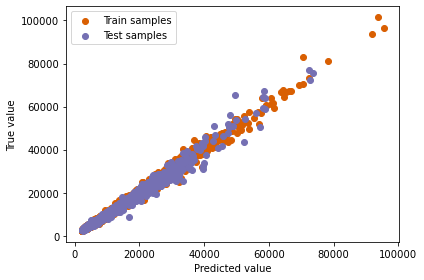

In [9]:
# Plot predictions

plt.scatter(train_predictions, y_train, label="Train samples", c='#d95f02')
plt.scatter(test_predictions, y_test, label="Test samples", c='#7570b3')
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.tight_layout()
plt.show()